In [23]:
# from google.colab import drive
# drive.mount('/content/drive')


# # To make this command work you need to add the folder data_assignment_2 to the root of your Google Drive 
# # Don't forget to upload the actual files there too
# # The best way to do this is the upload the data assignment zip and unzip the files in Google Drive. 
# # It kinda sucks but its one of the few ways to use Google Colab
# # When we turn this in, we might have to directly link to data so it can be run locally 
# %cd /content/drive/MyDrive/data_assignment_2

In [24]:
# Sanity check 
import os
print(os.listdir())


['TTGT_trades_2019.csv', '.DS_Store', 'TTGT_trades_2020.csv', 'data_assignment.ipynb', 'README.md', '.gitignore', '.gitattributes', 'TTGT_quotes_2020.csv', '.git', '.vscode', 'TTGT_quotes_2019.csv']


In [11]:
# Should be done within a minute on newer machines 
# I'm not sure if we should store the data files in a dict.
import pandas as pd
import numpy as np
df_dict = dict()
for file in os.listdir():
  if file[-4:] == ".csv":
    df_dict[file] = pd.read_csv(file)


In [12]:
#Taking only necessary columns

df_dict["TTGT_quotes_2019.csv"] = df_dict["TTGT_quotes_2019.csv"][['DATE', 'TIME_M', 'BID', 'BIDSIZ', 'ASK']]
df_dict["TTGT_quotes_2020.csv"] = df_dict["TTGT_quotes_2020.csv"][['DATE', 'TIME_M', 'BID', 'BIDSIZ', 'ASK']]
df_dict["TTGT_trades_2019.csv"] = df_dict["TTGT_trades_2019.csv"][['DATE', 'TIME_M', 'PRICE', 'SIZE']]
df_dict["TTGT_trades_2020.csv"] = df_dict["TTGT_trades_2020.csv"][['DATE', 'TIME_M', 'PRICE', 'SIZE']]
print(df_dict["TTGT_quotes_2019.csv"].columns)
print(df_dict["TTGT_quotes_2019.csv"].iloc[0][0])
print(df_dict["TTGT_quotes_2019.csv"].iloc[0][1])
print(df_dict["TTGT_trades_2019.csv"].columns)
print(df_dict["TTGT_trades_2019.csv"].iloc[0][0])
print(df_dict["TTGT_trades_2019.csv"].iloc[0][1])





Index(['DATE', 'TIME_M', 'BID', 'BIDSIZ', 'ASK'], dtype='object')
20190102
4:00:00.032946263
Index(['DATE', 'TIME_M', 'PRICE', 'SIZE'], dtype='object')
20190102
9:30:00.362466984


In [13]:
#trim milliseconds/seconds from time
for df in df_dict:
    if 'quotes' in df:
        df_dict[df]['TIME_M'] = df_dict[df]['TIME_M'].apply(lambda x: x[:-10])
    else:
        df_dict[df]['TIME_M'] = df_dict[df]['TIME_M'].apply(lambda x: x[:-13])

In [14]:
#check work
#print(df_dict["TTGT_quotes_2019.csv"].sort_values(by = ['DATE','TIME_M']))
#print(df_dict["TTGT_quotes_2019.csv"].groupby(['DATE', 'TIME_M'], as_index = False).mean().sort_values(by = ['DATE','TIME_M']))

#print(df_dict["TTGT_trades_2019.csv"].sort_values(by = ['DATE','TIME_M']))
#print(df_dict["TTGT_trades_2019.csv"].groupby(['DATE', 'TIME_M'], as_index = False).agg({'PRICE':'mean','SIZE':'sum'}).sort_values(by = ['DATE','TIME_M']))

Now we will aggregate the tables

In [15]:
#Average from milliseconds to seconds on quotes
df_dict["TTGT_quotes_2019.csv"] = df_dict["TTGT_quotes_2019.csv"].groupby(['DATE', 'TIME_M'], as_index = False).mean()
df_dict["TTGT_quotes_2020.csv"] = df_dict["TTGT_quotes_2020.csv"].groupby(['DATE', 'TIME_M'], as_index = False).mean()
#Averaging from seconds to minutes on trades
df_dict["TTGT_trades_2019.csv"] = df_dict["TTGT_trades_2019.csv"].groupby(['DATE', 'TIME_M'], as_index = False).agg({'PRICE':'mean','SIZE':'sum'})
df_dict["TTGT_trades_2020.csv"] = df_dict["TTGT_trades_2020.csv"].groupby(['DATE', 'TIME_M'], as_index = False).agg({'PRICE':'mean','SIZE':'sum'})

In [16]:
#getting weighted average on quotes
for df in df_dict:
    if 'quotes' in df:
        df_dict[df]['SECONDS'] = df_dict[df]['TIME_M'].apply(lambda x: x[-2:])
        df_dict[df]['TIME_M'] = df_dict[df]['TIME_M'].apply(lambda x: x[:-3])

In [17]:
#setting up the weights for weighted average
def generateWeights(df):
    weights = []
    currdate = None
    currtime = None
    prevSec = None
    for _, row in df.iterrows():
        date, time, second = row['DATE'], row['TIME_M'], row['SECONDS']
        if date != currdate:
            currdate = date
            currtime = time
            if prevSec != None:
                weights.append(60 - int(prevSec))
            prevSec = second
        else:
            if time != currtime:
                currtime = time
                weights.append(60-int(prevSec))
                prevSec = second
            else:
                weights.append(int(second) - int(prevSec))
                prevSec = second
    weights.append(60-int(prevSec))
    return weights

weights1 = generateWeights(df_dict["TTGT_quotes_2019.csv"])
weights2 = generateWeights(df_dict["TTGT_quotes_2020.csv"])


In [18]:
#Calculating weighted average

#Weighted average function
def weightedAverage(df):
    wm = lambda x: np.average(x, weights=df.loc[x.index, "WEIGHTS"])
    df = df.groupby(["DATE", "TIME_M"], as_index = False).agg(
        BID = ("BID", wm),
        BIDSIZ = ("BIDSIZ", wm),
        ASK = ("ASK",wm)
    )
    return df

#Setup 2019 and 2020 weights
df_dict["TTGT_quotes_2019.csv"]['WEIGHTS'] = pd.Series(weights1, index=df_dict["TTGT_quotes_2019.csv"].index)
df_dict["TTGT_quotes_2020.csv"]['WEIGHTS'] = pd.Series(weights2, index=df_dict["TTGT_quotes_2020.csv"].index)

df_dict["TTGT_quotes_2019.csv"] = weightedAverage(df_dict["TTGT_quotes_2019.csv"])
df_dict["TTGT_quotes_2020.csv"] = weightedAverage(df_dict["TTGT_quotes_2020.csv"])


In [19]:
#sanity check
#print(df_dict["TTGT_quotes_2019.csv"])
#print(df_dict["TTGT_quotes_2020.csv"])
#print(df_dict["TTGT_trades_2019.csv"])
#print(df_dict["TTGT_trades_2020.csv"])
#print(df_dict["TTGT_trades_2020.csv"][["DATE","TIME_M"]])

Plotting portion

In [20]:
#Instantiate plotting

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


/var/folders/s4/kp5y4dr14d19trtzc9ydqxvm0000gn/T/ipykernel_10714/3125587697.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/s4/kp5y4dr14d19trtzc9ydqxvm0000gn/T/ipykernel_10714/3125587697.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


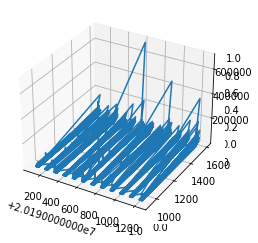

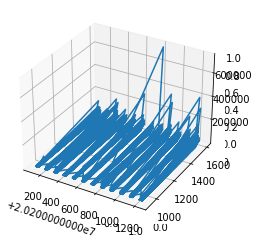

In [21]:
#PROBLEM 1: Volume Plot
required_data = df_dict["TTGT_trades_2019.csv"].copy()
required_data['TIME_M'] = required_data['TIME_M'].apply(lambda x: int(x.replace(':','')))
required_data = required_data[required_data['TIME_M'].between(930, 1600)]
x = required_data['DATE']
y = required_data['TIME_M']
z = required_data['SIZE']


fig = plt.figure()
ax = plt.axes(projection ='3d')

# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 

ax.plot3D(x, y, z)
fig.show()

required_data = df_dict["TTGT_trades_2020.csv"].copy()
required_data['TIME_M'] = required_data['TIME_M'].apply(lambda x: int(x.replace(':','')))
required_data = required_data[required_data['TIME_M'].between(930, 1600)]
x = required_data['DATE']
y = required_data['TIME_M']
z = required_data['SIZE']


fig = plt.figure()
ax = plt.axes(projection ='3d')

# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 

ax.plot3D(x, y, z)
fig.show()


/var/folders/s4/kp5y4dr14d19trtzc9ydqxvm0000gn/T/ipykernel_10714/309942369.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/s4/kp5y4dr14d19trtzc9ydqxvm0000gn/T/ipykernel_10714/309942369.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


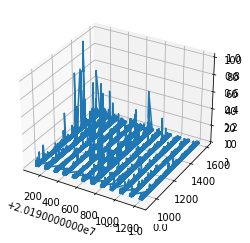

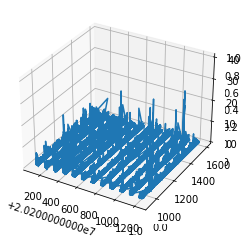

In [22]:
#PROBLEM 3: Bid Order Size
required_data = df_dict["TTGT_quotes_2019.csv"].copy()
required_data['TIME_M'] = required_data['TIME_M'].apply(lambda x: int(x.replace(':','')))
required_data = required_data[required_data['TIME_M'].between(930, 1600)]
x = required_data['DATE']
y = required_data['TIME_M']
z = required_data['BIDSIZ']


fig = plt.figure()
ax = plt.axes(projection ='3d')

# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 

ax.plot3D(x, y, z)
fig.show()

required_data = df_dict["TTGT_quotes_2020.csv"].copy()
required_data['TIME_M'] = required_data['TIME_M'].apply(lambda x: int(x.replace(':','')))
required_data = required_data[required_data['TIME_M'].between(930, 1600)]
x = required_data['DATE']
y = required_data['TIME_M']
z = required_data['BIDSIZ']


fig = plt.figure()
ax = plt.axes(projection ='3d')

# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 

ax.plot3D(x, y, z)
fig.show()


In [46]:
# Implement Random Selling Strategy
# We get sample a normal distribution for every opportunity to sell. 

volume_to_sell = 100000
time_to_sell = 100 # This is the amount of time intervals that we get to sell the stock 
sell_plan = []

remainding_volume = volume_to_sell
remainding_time = time_to_sell
for i in range(time_to_sell):
    # Dump whatever we have left in the end 
    if i == time_to_sell - 1:
        sell_plan.append(remainding_volume)
        remainding_volume -= sell_plan[i]
    else:
        # We also sell randomly. We don't want a consistant stream of selling, easy to get caught if we do so. 
        should_we_sell = np.random.randint(2) # 0 or 1
        if should_we_sell: 
            mu = 2 * remainding_volume / remainding_time # Time two because on average we only sell on half of the time deltas. 
            sigma = mu / 2
            cur_amount_to_sell = round(abs(np.random.normal(mu, sigma)), 2) # This may not be super matmatically sound...
        else:
            cur_amount_to_sell = 0
        
        # Adjust the volume and time. Also keep track of the amount we sell
        sell_plan.append(cur_amount_to_sell)
        remainding_volume -= sell_plan[i]
        remainding_time -= 1

In [47]:
# Santiy check
print(sum(sell_plan))
assert(int(sum(sell_plan)) == volume_to_sell)
print(sell_plan)

100000.00000000006
[2326.31, 0, 2136.29, 1419.74, 0, 379.04, 0, 0, 0, 3062.8, 2853.37, 0, 1687.12, 0, 3346.3, 1530.79, 0, 1186.26, 0, 1427.2, 0, 1776.97, 0, 361.45, 2647.04, 1464.84, 2082.99, 0, 1987.51, 1632.81, 1358.65, 0, 1833.25, 1203.32, 382.42, 0, 0, 0, 0, 3228.57, 1782.55, 77.41, 0, 1783.86, 0, 1822.29, 2282.7, 0, 0, 4458.28, 2648.92, 2343.48, 0, 0, 0, 792.92, 0, 0, 1133.88, 1330.99, 0, 0, 0, 0, 2833.71, 2945.97, 0, 1130.69, 1065.97, 1062.97, 0, 2814.94, 0, 942.66, 1733.55, 0, 2028.42, 0, 0, 3134.47, 2832.71, 0, 1415.96, 1825.65, 1527.08, 1969.19, 0, 1441.54, 855.35, 1393.4, 0, 1485.22, 868.93, 0, 1470.8, 93.59, 589.96, 693.51, 0, 71.44000000004621]
